In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install shap


In [5]:
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
import shap
#import matplotlib.pyplot as plt

/Users/tamoghnakumar/Desktop/vs/my_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import requests
import zipfile
import io
import os
from tqdm import tqdm

cricsheet_url = "https://cricsheet.org/downloads/all_json.zip"
extract_path = "./ipl_cricsheet_data"
os.makedirs(extract_path, exist_ok=True)

# Stream the response to get chunks
response = requests.get(cricsheet_url, stream=True)
total_size = int(response.headers.get('content-length', 0))
block_size = 1024  # 1 KB

# Download with progress bar
zip_bytes = io.BytesIO()
with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading Cricsheet data") as pbar:
    for data in response.iter_content(block_size):
        zip_bytes.write(data)
        pbar.update(len(data))

# Extract the zip contents
zip_file = zipfile.ZipFile(zip_bytes)
zip_file.extractall(extract_path)
print(f"✅ Extracted Cricsheet data to: {extract_path}")


✅ Extracted Cricsheet data to: ./ipl_cricsheet_data


In [7]:
def create_features():
    import requests
    import zipfile
    import io
    import os
    from tqdm import tqdm

    cricsheet_url = "https://cricsheet.org/downloads/all_json.zip"
    extract_path = "./ipl_cricsheet_data"
    os.makedirs(extract_path, exist_ok=True)

    # Stream the response to get chunks
    response = requests.get(cricsheet_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 KB

    # Download with progress bar
    zip_bytes = io.BytesIO()
    with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading Cricsheet data") as pbar:
        for data in response.iter_content(block_size):
            zip_bytes.write(data)
            pbar.update(len(data))

    # Extract the zip contents
    zip_file = zipfile.ZipFile(zip_bytes)
    zip_file.extractall(extract_path)
    print(f"✅ Extracted Cricsheet data to: {extract_path}")

    import os
    import json
    import pandas as pd
    from datetime import datetime

    # 🔹 Batting Points System
    Batting_points = {
        'Run': 1,
        'Boundary_Bonus': 4,
        'Six_Bonus': 6,
        '25Run_Bonus': 4,
        'Half_Century_Bonus': 8,
        '75Run_Bonus': 12,
        'Century_Bonus': 16,
        'Duck': -5  # Adjusted penalty for a duck
    }

    # 🔹 Bowling Points System
    Bowling_points = {
        'Dot_Ball': 1,
        'Wicket': 30,
        'Wicket_Bonus_LBW_Bowled': 8,
        '3_Wicket_Bonus': 4,
        '4_Wicket_Bonus': 8,
        '5_Wicket_Bonus': 12,
        'Hat-Trick_Bonus': 20,  # New hat-trick bonus
        'Maiden_Over': 12
    }

    # 🔹 Fielding Points System
    Fielding_points = {
        'Catch': 8,
        '3_Catch_Bonus': 4,
        'Stumping': 12,
        'Run_Out_Direct_Hit': 12,
        'Run_Out_Not_Direct_Hit': 6
    }

    # 🔹 Other Fantasy Bonuses
    Other_points = {
        'Captain_Multiplier': 2.0,
        'Vice_Captain_Multiplier': 1.5,
        'Announced_Lineup': 4
    }

    # 🔹 Economy Rate Adjustments
    Economy_points = {
        'Below_5': 6,
        '5_to_5.99': 4,
        '6_to_7': 2,
        '10_to_11': -2,
        '11.01_to_12': -4,
        'Above_12': -6
    }

    # 🔹 Strike Rate Adjustments
    StrikeRate_points = {
        'Above_170': 6,
        '150.01_to_170': 4,
        '130_to_150': 2,
        '60_to_70': -2,
        '50_to_59.99': -4,
        'Below_50': -6
    }

    def initialize_players(match_data):
        players = {}
        match_type= match_data['info']['match_type']
        series = match_data['info'].get('event', {}).get('name', 'Unknown Series')
        gender = match_data['info']['gender']
        registry_people = match_data['info']['registry']['people']
        for player in registry_people.keys():
            players[player] = {
                'runs': 0, 'balls_faced': 0, 'fours': 0, 'sixes': 0, 'is_out': False,
                'balls_bowled': 0, 'runs_conceded': 0, 'wickets': 0, 'dot_balls': 0, 'dismissals': [],
                'maiden_overs': 0, 'hat_trick': 0, 
                'catches': 0, 'stumpings': 0, 'run_outs_direct': 0, 'run_outs_indirect': 0,
                'team': None, 'in_lineup': False, 'captain': False, 'vice_captain': False, 'match_type' : match_type,
                'series' : series, 'gender' : gender
            }

        for team, squad in match_data['info']['players'].items():
            for player in squad:
                if player in players:
                    players[player]['team'] = team
                    players[player]['in_lineup'] = True

        return players

    def process_innings(match_data, players):
        """Process the match innings and update player statistics."""
        for inning in match_data['innings']:
            for over in inning['overs']:
                deliveries = over['deliveries']
                current_bowler = deliveries[0]['bowler'] if deliveries else None

                total_runs_in_over = sum(d['runs']['total'] for d in deliveries)
                if len(deliveries) == 6 and total_runs_in_over == 0:
                    players[current_bowler]['maiden_overs'] += 1

                # Track consecutive wickets for hat-trick calculation
                consecutive_wickets = 0

                for delivery in deliveries:
                    batter = delivery['batter']
                    bowler = delivery['bowler']
                    runs = delivery['runs']

                    players[batter]['runs'] += runs['batter']
                    players[batter]['balls_faced'] += 1
                    if runs['batter'] == 4:
                        players[batter]['fours'] += 1
                    elif runs['batter'] == 6:
                        players[batter]['sixes'] += 1

                    players[bowler]['balls_bowled'] += 1
                    players[bowler]['runs_conceded'] += runs['total']
                    if runs['total'] == 0:
                        players[bowler]['dot_balls'] += 1

                    if 'wickets' in delivery:
                        for wicket in delivery['wickets']:
                            players[bowler]['wickets'] += 1
                            players[bowler]['dismissals'].append(wicket['kind'])

                            consecutive_wickets += 1
                            if consecutive_wickets == 3:
                                players[bowler]['hat_trick'] = 1  # Hat-trick achieved!

                            players[wicket['player_out']]['is_out'] = True

    def calculate_fantasy_points(players):
        for player, stats in players.items():
            batting_points = 0
            bowling_points = 0
            fielding_points = 0
            economy_points = 0
            strike_rate_points = 0
            other_points = 0

            batting_points += stats['runs'] * Batting_points['Run']
            batting_points += stats['fours'] * Batting_points['Boundary_Bonus']
            batting_points += stats['sixes'] * Batting_points['Six_Bonus']

            if stats['runs'] >= 100:
                batting_points += Batting_points['Century_Bonus']
            elif stats['runs'] >= 75:
                batting_points += Batting_points['75Run_Bonus']
            elif stats['runs'] >= 50:
                batting_points += Batting_points['Half_Century_Bonus']
            elif stats['runs'] >= 25:
                batting_points += Batting_points['25Run_Bonus']

            if stats['is_out'] and stats['runs'] == 0:
                batting_points += Batting_points['Duck']

            bowling_points += stats['dot_balls'] * Bowling_points['Dot_Ball']
            bowling_points += stats['wickets'] * Bowling_points['Wicket']
            bowling_points += stats['maiden_overs'] * Bowling_points['Maiden_Over']

            if stats['hat_trick']:
                bowling_points += Bowling_points['Hat-Trick_Bonus']

            for dismissal in stats['dismissals']:
                if dismissal in ['bowled', 'lbw']:
                    bowling_points += Bowling_points['Wicket_Bonus_LBW_Bowled']

            if stats['wickets'] >= 3:
                bowling_points += Bowling_points['3_Wicket_Bonus']
            if stats['wickets'] >= 4:
                bowling_points += Bowling_points['4_Wicket_Bonus']
            if stats['wickets'] >= 5:
                bowling_points += Bowling_points['5_Wicket_Bonus']

            fielding_points += stats['catches'] * Fielding_points['Catch']
            if stats['catches'] >= 3:
                fielding_points += Fielding_points['3_Catch_Bonus']
            fielding_points += stats['stumpings'] * Fielding_points['Stumping']
            fielding_points += stats['run_outs_direct'] * Fielding_points['Run_Out_Direct_Hit']
            fielding_points += stats['run_outs_indirect'] * Fielding_points['Run_Out_Not_Direct_Hit']

            if stats['balls_bowled'] >= 12:  # At least 2 overs
                overs = stats['balls_bowled'] / 6
                economy = stats['runs_conceded'] / overs
                if economy < 5:
                    economy_points = Economy_points['Below_5']
                elif 5 <= economy < 6:
                    economy_points = Economy_points['5_to_5.99']
                elif 6 <= economy <= 7:
                    economy_points = Economy_points['6_to_7']
                elif 10 <= economy <= 11:
                    economy_points = Economy_points['10_to_11']
                elif 11.01 <= economy <= 12:
                    economy_points = Economy_points['11.01_to_12']
                elif economy > 12:
                    economy_points = Economy_points['Above_12']

            if stats['balls_faced'] >= 10 and stats['runs'] > 0:
                strike_rate = (stats['runs'] / stats['balls_faced']) * 100
                if strike_rate > 170:
                    strike_rate_points = StrikeRate_points['Above_170']
                elif 150.01 <= strike_rate <= 170:
                    strike_rate_points = StrikeRate_points['150.01_to_170']
                elif 130 <= strike_rate < 150:
                    strike_rate_points = StrikeRate_points['130_to_150']
                elif 60 <= strike_rate <= 70:
                    strike_rate_points = StrikeRate_points['60_to_70']
                elif 50 <= strike_rate < 60:
                    strike_rate_points = StrikeRate_points['50_to_59.99']
                elif strike_rate < 50:
                    strike_rate_points = StrikeRate_points['Below_50']

            if stats['in_lineup']:
                other_points = Other_points['Announced_Lineup']

            # Total Points (before multipliers)
            total_points = (
                batting_points +
                bowling_points +
                fielding_points +
                economy_points +
                strike_rate_points +
                other_points
            )


            players[player]['batting_points'] = round(batting_points, 2)
            players[player]['bowling_points'] = round(bowling_points, 2)
            players[player]['total_points'] = round(total_points, 2)
            players[player]['fantasy_points'] = round(total_points, 2) 

        df = pd.DataFrame.from_dict(players, orient='index')
        df["player_name"] = df.index

        df['strike_rate'] = df.apply(
            lambda x: (x['runs'] / x['balls_faced']) * 100 if x['balls_faced'] > 0 else 0,
            axis=1
        )
        df['economy_rate'] = df.apply(
            lambda x: (x['runs_conceded'] / (x['balls_bowled'] / 6)) if x['balls_bowled'] > 0 else 0,
            axis=1
        )

        df = df[df["in_lineup"] == True].reset_index(drop=True)

        columns = [
            'player_name', 'team', 'runs', 'balls_faced', 'fours', 'sixes', 'is_out',
            'wickets', 'balls_bowled', 'runs_conceded', 'dot_balls', 'maiden_overs', 'dismissals',
            'catches', 'stumpings', 'run_outs_direct', 'run_outs_indirect',
            'strike_rate', 'economy_rate', 'batting_points', 'bowling_points', 'total_points', 'match_type','series','gender'
        ]
        df = df[columns]

        return df

    def add_match_context(df, match_info, file_path):
        """Add match context with robust error handling."""
        # Date and season
        date_list = match_info.get('dates', [])
        date_str = date_list[0] if date_list else None
        season = None
        if date_str:
            try:
                season = pd.to_datetime(date_str).year
            except:
                season = None

        # Match metadata
        df['match_id'] = os.path.basename(file_path).split('.')[0]
        df['venue'] = match_info.get('venue', 'Unknown')
        df['date'] = date_str
        df['season'] = season

        # Toss info (handle missing keys)
        toss_info = match_info.get('toss', {})
        df['toss_winner'] = toss_info.get('winner', 'Unknown')
        df['toss_decision'] = toss_info.get('decision', 'Unknown')

        # Match outcome (handle "No Result" or "Super Over")
        outcome_info = match_info.get('outcome', {})
        if 'winner' in outcome_info:
            df['match_winner'] = outcome_info['winner']
        elif 'method' in outcome_info:
            df['match_winner'] = f"Match {outcome_info['method']}"
        else:
            df['match_winner'] = 'Unknown'

        # Opposition team (handle invalid/missing teams list)
        teams = match_info.get('teams', [])
        df['opposition'] = df['team'].apply(
            lambda x: (
                teams[0] if x == teams[1]
                else teams[1] if len(teams) >= 2
                else 'Unknown'
            )
        )

        return df

    def process_match(file_path):
        with open(file_path, "r") as file:
            match_data = json.load(file)

        players = initialize_players(match_data)
        process_innings(match_data, players)
        df = calculate_fantasy_points(players)


        # Add match metadata
        match_info = match_data['info']
        df = add_match_context(df, match_info, file_path)

        return df

    all_matches = []
    directory = "./ipl_cricsheet_data"
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename)
            try:
                match_df = process_match(file_path)
                all_matches.append(match_df)
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    final_df = pd.concat(all_matches, ignore_index=True)

    final_df['date'] = pd.to_datetime(final_df['date'], errors='coerce')
    final_df = final_df.sort_values('date', ascending=True).reset_index(drop=True)


    # # Rename the variable to avoid the conflict
    # player_name_current = player_name

    final_df = final_df.sort_values(by=["player_name", "date"]).reset_index(drop=True)
    final_df['total_fantasy_score']=final_df['total_points']
    final_df.drop('total_points', axis=1, inplace=True)
    final_df = final_df[final_df['gender']=='male']

    people=pd.read_csv('/Users/namansethi/Downloads/people.csv')

    # Create two mapping dictionaries from people DataFrame
    name_map = dict(zip(people['name'], people['identifier']))
    unique_name_map = dict(zip(people['unique_name'], people['identifier']))

    # Try matching player_name with 'name' first, then with 'unique_name'
    final_df['player_id'] = final_df['player_name'].map(name_map).fillna(final_df['player_name'].map(unique_name_map))

    def prepare_data(data, cutoff_date):
        """Prepare and sort data, set date format, and apply cutoff date."""
        data['date'] = pd.to_datetime(data['date'])  # Ensure 'start_date' is in datetime format
        data = data.sort_values(['player_id', 'date'])
        return data[data['date'] < cutoff_date]

    def calculate_rolling_fantasy_score(group):
        """Calculate the rolling average of fantasy scores."""
        group['avg_fantasy_score_1_all'] = group['total_fantasy_score'].rolling(1, min_periods=1).mean()
        group['avg_fantasy_score_3_all'] = group['total_fantasy_score'].rolling(3, min_periods=1).mean()
        group['avg_fantasy_score_5_all'] = group['total_fantasy_score'].rolling(5, min_periods=1).mean()
        group['avg_fantasy_score_10_all'] = group['total_fantasy_score'].rolling(10, min_periods=5).mean()
        group['avg_fantasy_score_15_all'] = group['total_fantasy_score'].rolling(15, min_periods=10).mean()
        group['avg_fantasy_score_20_all'] = group['total_fantasy_score'].rolling(20, min_periods=15).mean()
        group['avg_fantasy_score_30_all'] = group['total_fantasy_score'].rolling(30, min_periods=20).mean()
        return group

    def player_features(data):
        """Add rolling fantasy score features directly to the original data DataFrame."""
        cutoff_date = pd.to_datetime('2025-05-20')
        data = prepare_data(data, cutoff_date)

        # Apply rolling calculations directly to each group
        data = data.groupby('player_id', group_keys=False).apply(calculate_rolling_fantasy_score)

        return data  # <- returning the full data with added columns

    final_df=player_features(final_df)

    series=['Syed Mushtaq Ali Trophy', 'Indian Premier League','Super Smash', 'India v England',
       'India tour of England', 'Pakistan tour of England', 'New Zealand tour of Bangladesh',
       'England tour of New Zealand', 'England tour of Bangladesh', 'MCC Spirit of Cricket T20I Series',
       'Pakistan in England T20I Series', 'India tour of Zimbabwe', 'India tour of United States of America and West Indies',
       'Australia in West Indies T20I Series', 'T20 Canada',
       'India in New Zealand T20I Series',
       'Australia in New Zealand T20I Series',
       'New Zealand in Zimbabwe T20I Series',
       'West Indies in Australia T20I Series',
       'Bangladesh tour of India', 'West Indies tour of Bangladesh',
       'Pakistan v Australia T20I Series', 'Pakistan in West Indies T20I Series', 
       'New Zealand tour of United Arab Emirates', 'Caribbean Premier League',
       'South Africa tour of West Indies', 'Big Bash League', 'Walton T20 Cricket Series',
        'India tour of West Indies', 'New Zealand tour of West Indies',
       'India tour of West Indies and United States of America',
       'ICC World Twenty20 Qualifier', 'NatWest T20 Blast','India tour of Ireland and England','Ireland tour of West Indies',
       'Vitality Blast', 'South Africa tour of Ireland',"ICC Men's T20 World Cup",'South Africa tour of England','Bangladesh Premier League', 'India tour of Sri Lanka',
       'Sri Lanka tour of India', 'Sri Lanka tour of Bangladesh', 'Nidahas Trophy', 'South Africa tour of Sri Lanka',
       'Sri Lanka tour of South Africa', 'New Zealand tour of Sri Lanka',
       'Lanka Premier League', 'Sri Lanka tour of West Indies', 'Australia in South Africa T20I Series',
       'Australia in Sri Lanka T20I Series', 'Australia tour of India',
       'Trans-Tasman Twenty20 Trophy', 'Australia tour of United Arab Emirates',
       'India tour of Australia', 'Sri Lanka tour of Australia', 'New Zealand tour of England', 'England tour of West Indies',
       'England tour of India', 'Pakistan in India T20I Series',
       'West Indies in South Africa T20I Series', 'Pakistan tour of Ireland, England and Scotland',
       'New Zealand tour of Scotland', 'Australia in England T20I Series',
       'South Africa in Australia T20I Series', 'West Indies in England T20I Series',
       'England in New Zealand T20I Series',
       'New Zealand in England T20I Series',
       'England in West Indies T20I Series',
       'West Indies tour of England', 'England tour of Sri Lanka',
       'England tour of Pakistan', 'New Zealand in Sri Lanka T20I Series',
       'New Zealand v Sri Lanka T20I Series',
       'Pakistan in Sri Lanka T20I Series',
       'Pakistan v Sri Lanka T20I Series',
       'Sri Lanka in Bangladesh T20I Series',
       'West Indies in Sri Lanka T20I Series',
       'Sri Lanka in New Zealand T20I Series',
       'West Indies tour of Sri Lanka', 'Zimbabwe tour of Sri Lanka',
       'Ireland in West Indies T20I Series',
       'Zimbabwe in West Indies T20I Series',
       'West Indies in New Zealand T20I Series',
       'New Zealand in West Indies T20I Series',
       'ICC World XI tour of England',
       'Bangladesh tour of West Indies and United States of America',
       'Pakistan tour of West Indies',
       'Pakistan v West Indies T20I Series',
       'West Indies tour of New Zealand', 'West Indies tour of Pakistan',
       'Bangladesh tour of West Indies',
       'Pakistan in New Zealand T20I Series',
       'New Zealand in India T20I Series',
       'Pakistan v New Zealand T20I Series',
       'Bangladesh tour of New Zealand', 'New Zealand T20I Tri-Series',
       'India tour of New Zealand', 'Sri Lanka tour of New Zealand',
       'New Zealand tour of Pakistan', 'Pakistan tour of New Zealand',
       'England in South Africa T20I Series',
       'South Africa in West Indies T20I Series',
       'Pakistan v South Africa T20I Series',
       'South Africa in New Zealand T20I Series',
       'South Africa in England T20I Series',
       'Pakistan in South Africa T20I Series',
       'South Africa in Sri Lanka T20I Series',
       'South Africa in Bangladesh T20I Series',
       'New Zealand in South Africa T20I Series',
       'South Africa in India T20I Series',
       'Sri Lanka in South Africa T20I Series',
       'Bangladesh tour of South Africa', 'Zimbabwe Twenty20 Tri-Series',
       'Australia tour of Sri Lanka',
       'Pakistan tour of Australia', 'Australia tour of England',
       'Australia tour of New Zealand', 'Australia tour of West Indies',
       'Australia tour of Bangladesh', 'Australia tour of Pakistan',
       'West Indies tour of Australia', 'England tour of Australia',
       'Sri Lanka tour of England', 'SA20','Major League Cricket','Mzansi Super League', 'Pakistan Super League', "The Hundred Men's Competition",'West Indies v India T20I Series',
       'England in India T20I Series','Bangladesh Twenty20 Tri-Series','Sri Lanka in India T20I Series', 'India in Australia T20I Series',
       'Asia Cup', 'New Zealand tour of India', 'Pakistan v England T20I Series',
       'England in Australia T20I Series',       'Gulf Cricket T20I Championship',
'India tour of South Africa', 'Pakistan tour of South Africa',

       'South Africa tour of India', 'Australia tour of South Africa',
       'England tour of South Africa', 'West Indies tour of South Africa']
    final_df = final_df[final_df['series'].isin(series)]
    final_df.shape

    final_df = final_df[(final_df['match_type'] == 'T20') | (final_df['match_type'] == 'IT20')]

    def prepare_data(data, cutoff_date):
        """Prepare and sort data, set date format, and apply cutoff date."""
        data['date'] = pd.to_datetime(data['date'])  # Ensure 'start_date' is in datetime format
        data = data.sort_values(['player_id', 'date'])
        return data[data['date'] < cutoff_date]

    def calculate_rolling_fantasy_score(group):
        """Calculate the rolling average of fantasy scores."""
        group['avg_fantasy_score_batting_3'] = group['batting_points'].rolling(3, min_periods=1).mean()
        group['avg_fantasy_score_batting_1'] = group['batting_points'].rolling(1, min_periods=1).mean()
        group['avg_fantasy_score_batting_5'] = group['batting_points'].rolling(5, min_periods=1).mean()

        group['avg_fantasy_score_bowling_3'] = group['bowling_points'].rolling(3, min_periods=1).mean()
        group['avg_fantasy_score_bowling_1'] = group['bowling_points'].rolling(1, min_periods=1).mean()
        group['avg_fantasy_score_bowling_5'] = group['bowling_points'].rolling(5, min_periods=1).mean()

        return group

    def player_features(data):
        """Add rolling fantasy score features directly to the original data DataFrame."""
        cutoff_date = pd.to_datetime('2025-05-20')
        data = prepare_data(data, cutoff_date)

        # Apply rolling calculations directly to each group
        data = data.groupby('player_id', group_keys=False).apply(calculate_rolling_fantasy_score)

        return data  # <- returning the full data with added columns

    final_df=player_features(final_df)
    batsman = []
    for i in range(len(final_df)):
        if final_df['avg_fantasy_score_batting_5'].iloc[i] >= 1.5 * final_df['avg_fantasy_score_bowling_5'].iloc[i]:
            batsman.append(1)
        else:
            batsman.append(0)
    final_df['batsman']=batsman
    batsman=final_df[final_df['batsman']==1]
    bowler=final_df[final_df['batsman']==0]

    def prepare_data(data, cutoff_date):
        """Prepare and sort data, set date format, and apply cutoff date."""
        data['date'] = pd.to_datetime(data['date'])  # Ensure 'start_date' is in datetime format
        data = data.sort_values(['player_id', 'date'])
        return data[data['date'] < cutoff_date]

    def calculate_rolling_fantasy_score(group):
        """Calculate the rolling average of fantasy scores."""
        group['avg_fantasy_score_1'] = group['total_fantasy_score'].rolling(1, min_periods=1).mean()
        group['avg_fantasy_score_3'] = group['total_fantasy_score'].rolling(3, min_periods=1).mean()
        group['avg_fantasy_score_5'] = group['total_fantasy_score'].rolling(5, min_periods=1).mean()
        group['avg_fantasy_score_10'] = group['total_fantasy_score'].rolling(10, min_periods=5).mean()
        group['avg_fantasy_score_15'] = group['total_fantasy_score'].rolling(15, min_periods=10).mean()
        group['avg_fantasy_score_20'] = group['total_fantasy_score'].rolling(20, min_periods=15).mean()
        group['avg_fantasy_score_30'] = group['total_fantasy_score'].rolling(30, min_periods=20).mean()
        return group

    def player_features(data):
        """Add rolling fantasy score features directly to the original data DataFrame."""
        cutoff_date = pd.to_datetime('2025-05-20')
        data = prepare_data(data, cutoff_date)

        # Apply rolling calculations directly to each group
        data = data.groupby('player_id', group_keys=False).apply(calculate_rolling_fantasy_score)

        return data  # <- returning the full data with added columns

    batsman=player_features(batsman)
    bowler=player_features(bowler)

    batsman=batsman[(batsman['series']=='Indian Premier League' ) | (batsman['series']=='SA20') | (batsman['series']=='International League T20') | (batsman['series']=='Big Bash League')  | (batsman['series']=="The Hundred Men's Competition")]
    bowler=bowler[(bowler['series']=='Indian Premier League') | (bowler['series']=='SA20') | (bowler['series']=='International League T20') | (bowler['series']=='Big Bash League') | (bowler['series']=="The Hundred Men's Competition")] 

    
    cols=['match_id','date','total_fantasy_score', 'player_id','batting_points','bowling_points',
        'avg_fantasy_score_1_all', 'avg_fantasy_score_3_all',
       'avg_fantasy_score_5_all', 'avg_fantasy_score_10_all',
       'avg_fantasy_score_15_all', 'avg_fantasy_score_20_all',
       'avg_fantasy_score_30_all', 'avg_fantasy_score_batting_3', 'avg_fantasy_score_bowling_3','avg_fantasy_score_batting_5',
       'avg_fantasy_score_bowling_5', 'avg_fantasy_score_batting_1','avg_fantasy_score_bowling_1', 
       'avg_fantasy_score_1', 'avg_fantasy_score_3', 'avg_fantasy_score_5',
       'avg_fantasy_score_10', 'avg_fantasy_score_15', 'avg_fantasy_score_20',
       'series', 'avg_fantasy_score_30',  'venue' ]
    
    bowler=bowler[cols]
    batsman=batsman[cols]

    def prepare_data(data, cutoff_date):
        """Prepare and sort data, set date format, and apply cutoff date."""
        data['date'] = pd.to_datetime(data['date'])  # Ensure 'start_date' is in datetime format
        data = data.sort_values(['player_id', 'date'])
        return data[data['date'] < cutoff_date]

    def calculate_rolling_fantasy_score(group):
        """Calculate the rolling average of fantasy scores."""
        group['avg_fantasy_score_1_ipl'] = group['total_fantasy_score'].rolling(1, min_periods=1).mean()
        group['avg_fantasy_score_3_ipl'] = group['total_fantasy_score'].rolling(3, min_periods=1).mean()
        group['avg_fantasy_score_5_ipl'] = group['total_fantasy_score'].rolling(5, min_periods=3).mean()
        group['avg_fantasy_score_10_ipl'] = group['total_fantasy_score'].rolling(10, min_periods=5).mean()
        group['avg_fantasy_score_15_ipl'] = group['total_fantasy_score'].rolling(15, min_periods=10).mean()
        group['avg_fantasy_score_20_ipl'] = group['total_fantasy_score'].rolling(20, min_periods=15).mean()
        return group

    def player_features2(data):
        """Add rolling fantasy score features directly to the original data DataFrame."""
        cutoff_date = pd.to_datetime('2025-05-20')
        data = prepare_data(data, cutoff_date)

        # Apply rolling calculations directly to each group
        data = data.groupby('player_id', group_keys=False).apply(calculate_rolling_fantasy_score)

        return data  # <- returning the full data with added columns

    batsman=player_features2(batsman)
    bowler=player_features2(bowler)

    batsman=batsman[batsman['date']>='2020-01-01']
    bowler=bowler[bowler['date']>='2020-01-01']
    
    return batsman,bowler

In [8]:
!cat ipl_cricsheet_data/README.txt

This zip archive contains data files from Cricsheet in JSON format. This
archive contains 18646 matches. A further 340 matches have been withheld due
to either featuring the Afghanistan men's team or being played in the
Afghanistan Premier League, due to the Cricsheet policy to no longer feature
matches involving Afghanistan men or played in Afghanistan Premier League (see
https://cricsheet.org/withheld-matches for more information).


The JSON data files contained in this zip file are version 1.0.0, and 1.1.0
files. You can learn about the structure of these files at
https://cricsheet.org/format/json/


You can find the available downloads at https://cricsheet.org/downloads/, and
you can find the most up-to-date version of this zip file at
https://cricsheet.org/downloads/all_json.zip


The matches contained in this zip archive are listed below. The first field is
the start date of the match (for test matches or other multi-day matches), or
the actual date (for all other types of match

In [9]:
import os
import json
import pandas as pd
from datetime import datetime

# 🔹 Batting Points System
Batting_points = {
    'Run': 1,
    'Boundary_Bonus': 4,
    'Six_Bonus': 6,
    '25Run_Bonus': 4,
    'Half_Century_Bonus': 8,
    '75Run_Bonus': 12,
    'Century_Bonus': 16,
    'Duck': -5  # Adjusted penalty for a duck
}

# 🔹 Bowling Points System
Bowling_points = {
    'Dot_Ball': 1,
    'Wicket': 30,
    'Wicket_Bonus_LBW_Bowled': 8,
    '3_Wicket_Bonus': 4,
    '4_Wicket_Bonus': 8,
    '5_Wicket_Bonus': 12,
    'Hat-Trick_Bonus': 20,  # New hat-trick bonus
    'Maiden_Over': 12
}

# 🔹 Fielding Points System
Fielding_points = {
    'Catch': 8,
    '3_Catch_Bonus': 4,
    'Stumping': 12,
    'Run_Out_Direct_Hit': 12,
    'Run_Out_Not_Direct_Hit': 6
}

# 🔹 Other Fantasy Bonuses
Other_points = {
    'Captain_Multiplier': 2.0,
    'Vice_Captain_Multiplier': 1.5,
    'Announced_Lineup': 4
}

# 🔹 Economy Rate Adjustments
Economy_points = {
    'Below_5': 6,
    '5_to_5.99': 4,
    '6_to_7': 2,
    '10_to_11': -2,
    '11.01_to_12': -4,
    'Above_12': -6
}

# 🔹 Strike Rate Adjustments
StrikeRate_points = {
    'Above_170': 6,
    '150.01_to_170': 4,
    '130_to_150': 2,
    '60_to_70': -2,
    '50_to_59.99': -4,
    'Below_50': -6
}



In [10]:
def initialize_players(match_data):
    players = {}
    match_type= match_data['info']['match_type']
    series = match_data['info'].get('event', {}).get('name', 'Unknown Series')
    gender = match_data['info']['gender']
    registry_people = match_data['info']['registry']['people']
    for player in registry_people.keys():
        players[player] = {
            'runs': 0, 'balls_faced': 0, 'fours': 0, 'sixes': 0, 'is_out': False,
            'balls_bowled': 0, 'runs_conceded': 0, 'wickets': 0, 'dot_balls': 0, 'dismissals': [],
            'maiden_overs': 0, 'hat_trick': 0, 
            'catches': 0, 'stumpings': 0, 'run_outs_direct': 0, 'run_outs_indirect': 0,
            'team': None, 'in_lineup': False, 'captain': False, 'vice_captain': False, 'match_type' : match_type,
            'series' : series, 'gender' : gender
        }

    for team, squad in match_data['info']['players'].items():
        for player in squad:
            if player in players:
                players[player]['team'] = team
                players[player]['in_lineup'] = True

    return players

In [11]:
def process_innings(match_data, players):
    """Process the match innings and update player statistics."""
    for inning in match_data['innings']:
        for over in inning['overs']:
            deliveries = over['deliveries']
            current_bowler = deliveries[0]['bowler'] if deliveries else None

            total_runs_in_over = sum(d['runs']['total'] for d in deliveries)
            if len(deliveries) == 6 and total_runs_in_over == 0:
                players[current_bowler]['maiden_overs'] += 1

            # Track consecutive wickets for hat-trick calculation
            consecutive_wickets = 0

            for delivery in deliveries:
                batter = delivery['batter']
                bowler = delivery['bowler']
                runs = delivery['runs']

                players[batter]['runs'] += runs['batter']
                players[batter]['balls_faced'] += 1
                if runs['batter'] == 4:
                    players[batter]['fours'] += 1
                elif runs['batter'] == 6:
                    players[batter]['sixes'] += 1

                players[bowler]['balls_bowled'] += 1
                players[bowler]['runs_conceded'] += runs['total']
                if runs['total'] == 0:
                    players[bowler]['dot_balls'] += 1

                if 'wickets' in delivery:
                    for wicket in delivery['wickets']:
                        players[bowler]['wickets'] += 1
                        players[bowler]['dismissals'].append(wicket['kind'])

                        consecutive_wickets += 1
                        if consecutive_wickets == 3:
                            players[bowler]['hat_trick'] = 1  # Hat-trick achieved!

                        players[wicket['player_out']]['is_out'] = True


In [12]:
def calculate_fantasy_points(players):
    for player, stats in players.items():
        batting_points = 0
        bowling_points = 0
        fielding_points = 0
        economy_points = 0
        strike_rate_points = 0
        other_points = 0

        batting_points += stats['runs'] * Batting_points['Run']
        batting_points += stats['fours'] * Batting_points['Boundary_Bonus']
        batting_points += stats['sixes'] * Batting_points['Six_Bonus']

        if stats['runs'] >= 100:
            batting_points += Batting_points['Century_Bonus']
        elif stats['runs'] >= 75:
            batting_points += Batting_points['75Run_Bonus']
        elif stats['runs'] >= 50:
            batting_points += Batting_points['Half_Century_Bonus']
        elif stats['runs'] >= 25:
            batting_points += Batting_points['25Run_Bonus']

        if stats['is_out'] and stats['runs'] == 0:
            batting_points += Batting_points['Duck']

        bowling_points += stats['dot_balls'] * Bowling_points['Dot_Ball']
        bowling_points += stats['wickets'] * Bowling_points['Wicket']
        bowling_points += stats['maiden_overs'] * Bowling_points['Maiden_Over']

        if stats['hat_trick']:
            bowling_points += Bowling_points['Hat-Trick_Bonus']

        for dismissal in stats['dismissals']:
            if dismissal in ['bowled', 'lbw']:
                bowling_points += Bowling_points['Wicket_Bonus_LBW_Bowled']

        if stats['wickets'] >= 3:
            bowling_points += Bowling_points['3_Wicket_Bonus']
        if stats['wickets'] >= 4:
            bowling_points += Bowling_points['4_Wicket_Bonus']
        if stats['wickets'] >= 5:
            bowling_points += Bowling_points['5_Wicket_Bonus']

        fielding_points += stats['catches'] * Fielding_points['Catch']
        if stats['catches'] >= 3:
            fielding_points += Fielding_points['3_Catch_Bonus']
        fielding_points += stats['stumpings'] * Fielding_points['Stumping']
        fielding_points += stats['run_outs_direct'] * Fielding_points['Run_Out_Direct_Hit']
        fielding_points += stats['run_outs_indirect'] * Fielding_points['Run_Out_Not_Direct_Hit']

        if stats['balls_bowled'] >= 12:  # At least 2 overs
            overs = stats['balls_bowled'] / 6
            economy = stats['runs_conceded'] / overs
            if economy < 5:
                economy_points = Economy_points['Below_5']
            elif 5 <= economy < 6:
                economy_points = Economy_points['5_to_5.99']
            elif 6 <= economy <= 7:
                economy_points = Economy_points['6_to_7']
            elif 10 <= economy <= 11:
                economy_points = Economy_points['10_to_11']
            elif 11.01 <= economy <= 12:
                economy_points = Economy_points['11.01_to_12']
            elif economy > 12:
                economy_points = Economy_points['Above_12']

        if stats['balls_faced'] >= 10 and stats['runs'] > 0:
            strike_rate = (stats['runs'] / stats['balls_faced']) * 100
            if strike_rate > 170:
                strike_rate_points = StrikeRate_points['Above_170']
            elif 150.01 <= strike_rate <= 170:
                strike_rate_points = StrikeRate_points['150.01_to_170']
            elif 130 <= strike_rate < 150:
                strike_rate_points = StrikeRate_points['130_to_150']
            elif 60 <= strike_rate <= 70:
                strike_rate_points = StrikeRate_points['60_to_70']
            elif 50 <= strike_rate < 60:
                strike_rate_points = StrikeRate_points['50_to_59.99']
            elif strike_rate < 50:
                strike_rate_points = StrikeRate_points['Below_50']

        if stats['in_lineup']:
            other_points = Other_points['Announced_Lineup']

        # Total Points (before multipliers)
        total_points = (
            batting_points +
            bowling_points +
            fielding_points +
            economy_points +
            strike_rate_points +
            other_points
        )


        players[player]['batting_points'] = round(batting_points, 2)
        players[player]['bowling_points'] = round(bowling_points, 2)
        players[player]['total_points'] = round(total_points, 2)
        players[player]['fantasy_points'] = round(total_points, 2) 

    df = pd.DataFrame.from_dict(players, orient='index')
    df["player_name"] = df.index

    df['strike_rate'] = df.apply(
        lambda x: (x['runs'] / x['balls_faced']) * 100 if x['balls_faced'] > 0 else 0,
        axis=1
    )
    df['economy_rate'] = df.apply(
        lambda x: (x['runs_conceded'] / (x['balls_bowled'] / 6)) if x['balls_bowled'] > 0 else 0,
        axis=1
    )

    df = df[df["in_lineup"] == True].reset_index(drop=True)

    columns = [
        'player_name', 'team', 'runs', 'balls_faced', 'fours', 'sixes', 'is_out',
        'wickets', 'balls_bowled', 'runs_conceded', 'dot_balls', 'maiden_overs', 'dismissals',
        'catches', 'stumpings', 'run_outs_direct', 'run_outs_indirect',
        'strike_rate', 'economy_rate', 'batting_points', 'bowling_points', 'total_points', 'match_type','series','gender'
    ]
    df = df[columns]

    return df

In [13]:
def add_match_context(df, match_info, file_path):
    """Add match context with robust error handling."""
    # Date and season
    date_list = match_info.get('dates', [])
    date_str = date_list[0] if date_list else None
    season = None
    if date_str:
        try:
            season = pd.to_datetime(date_str).year
        except:
            season = None

    # Match metadata
    df['match_id'] = os.path.basename(file_path).split('.')[0]
    df['venue'] = match_info.get('venue', 'Unknown')
    df['date'] = date_str
    df['season'] = season

    # Toss info (handle missing keys)
    toss_info = match_info.get('toss', {})
    df['toss_winner'] = toss_info.get('winner', 'Unknown')
    df['toss_decision'] = toss_info.get('decision', 'Unknown')

    # Match outcome (handle "No Result" or "Super Over")
    outcome_info = match_info.get('outcome', {})
    if 'winner' in outcome_info:
        df['match_winner'] = outcome_info['winner']
    elif 'method' in outcome_info:
        df['match_winner'] = f"Match {outcome_info['method']}"
    else:
        df['match_winner'] = 'Unknown'

    # Opposition team (handle invalid/missing teams list)
    teams = match_info.get('teams', [])
    df['opposition'] = df['team'].apply(
        lambda x: (
            teams[0] if x == teams[1]
            else teams[1] if len(teams) >= 2
            else 'Unknown'
        )
    )

    return df

In [14]:
def process_match(file_path):
    with open(file_path, "r") as file:
        match_data = json.load(file)

    players = initialize_players(match_data)
    process_innings(match_data, players)
    df = calculate_fantasy_points(players)


    # Add match metadata
    match_info = match_data['info']
    df = add_match_context(df, match_info, file_path)

    return df

In [15]:
all_matches = []
directory = "./ipl_cricsheet_data"
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        file_path = os.path.join(directory, filename)
        try:
            match_df = process_match(file_path)
            all_matches.append(match_df)
        except Exception as e:
            print(f"Error processing {filename}: {e}")

final_df = pd.concat(all_matches, ignore_index=True)

final_df['date'] = pd.to_datetime(final_df['date'], errors='coerce')
final_df = final_df.sort_values('date', ascending=True).reset_index(drop=True)

final_df.to_csv("sorted_ipl_dataset.csv", index=False)

Error processing 1160280.json: 'overs'
Error processing 1244270.json: 'overs'
Error processing 1410315.json: 'overs'
Error processing 804289.json: 'overs'
Error processing 1160298.json: 'overs'
Error processing 1166966.json: 'overs'
Error processing 1227605.json: 'overs'
Error processing 1280007.json: 'overs'
Error processing 1234907.json: 'overs'


In [16]:
# # Rename the variable to avoid the conflict
# player_name_current = player_name

final_df = final_df.sort_values(by=["player_name", "date"]).reset_index(drop=True)


In [17]:
final_df.columns

Index(['player_name', 'team', 'runs', 'balls_faced', 'fours', 'sixes',
       'is_out', 'wickets', 'balls_bowled', 'runs_conceded', 'dot_balls',
       'maiden_overs', 'dismissals', 'catches', 'stumpings', 'run_outs_direct',
       'run_outs_indirect', 'strike_rate', 'economy_rate', 'batting_points',
       'bowling_points', 'total_points', 'match_type', 'series', 'gender',
       'match_id', 'venue', 'date', 'season', 'toss_winner', 'toss_decision',
       'match_winner', 'opposition'],
      dtype='object')

In [18]:
final_df['total_fantasy_score']=final_df['total_points']
final_df.drop('total_points', axis=1, inplace=True)

In [20]:
# final_df['total_fantasy_score']=final_df['total_points']
# final_df.drop('total_points', axis=1, inplace=True)
final_df = final_df[final_df['gender']=='male']

In [21]:
final_df = final_df[final_df['gender']=='male']

In [91]:
names=pd.read_csv('/Users/tamoghnakumar/Desktop/names_naman.csv')
people=pd.read_csv('/Users/tamoghnakumar/Desktop/people_naman.csv')

In [92]:
# Create two mapping dictionaries from people DataFrame
name_map = dict(zip(people['name'], people['identifier']))
unique_name_map = dict(zip(people['unique_name'], people['identifier']))

# Try matching player_name with 'name' first, then with 'unique_name'
final_df['player_id'] = final_df['player_name'].map(name_map).fillna(final_df['player_name'].map(unique_name_map))


In [93]:
def prepare_data(data, cutoff_date):
    """Prepare and sort data, set date format, and apply cutoff date."""
    data['date'] = pd.to_datetime(data['date'])  # Ensure 'start_date' is in datetime format
    data = data.sort_values(['player_id', 'date'])
    return data[data['date'] < cutoff_date]

def calculate_rolling_fantasy_score(group):
    """Calculate the rolling average of fantasy scores."""
    group['avg_fantasy_score_1_all'] = group['total_fantasy_score'].shift().rolling(1, min_periods=1).mean()
    group['avg_fantasy_score_3_all'] = group['total_fantasy_score'].shift().rolling(3, min_periods=1).mean()
    group['avg_fantasy_score_5_all'] = group['total_fantasy_score'].shift().rolling(5, min_periods=1).mean()
    group['avg_fantasy_score_10_all'] = group['total_fantasy_score'].shift().rolling(10, min_periods=5).mean()
    group['avg_fantasy_score_15_all'] = group['total_fantasy_score'].shift().rolling(15, min_periods=10).mean()
    group['avg_fantasy_score_20_all'] = group['total_fantasy_score'].shift().rolling(20, min_periods=15).mean()
    group['avg_fantasy_score_30_all'] = group['total_fantasy_score'].shift().rolling(30, min_periods=20).mean()
    return group

def player_features(data):
    """Add rolling fantasy score features directly to the original data DataFrame."""
    cutoff_date = pd.to_datetime('2025-05-20')
    data = prepare_data(data, cutoff_date)

    # Apply rolling calculations directly to each group
    data = data.groupby('player_id', group_keys=False).apply(calculate_rolling_fantasy_score)

    return data  # <- returning the full data with added columns


In [94]:
final_df=player_features(final_df)

/var/folders/wc/yydrg2wj7zb6sxtvg6h8nmcw0000gn/T/ipykernel_38370/2925119526.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('player_id', group_keys=False).apply(calculate_rolling_fantasy_score)


In [95]:
series=['Syed Mushtaq Ali Trophy', 'Indian Premier League','Super Smash', 'India v England',
       'India tour of England', 'Pakistan tour of England', 'New Zealand tour of Bangladesh',
       'England tour of New Zealand', 'England tour of Bangladesh', 'MCC Spirit of Cricket T20I Series',
       'Pakistan in England T20I Series', 'India tour of Zimbabwe', 'India tour of United States of America and West Indies',
       'Australia in West Indies T20I Series', 'T20 Canada',
       'India in New Zealand T20I Series',
       'Australia in New Zealand T20I Series',
       'New Zealand in Zimbabwe T20I Series',
       'West Indies in Australia T20I Series',
       'Bangladesh tour of India', 'West Indies tour of Bangladesh',
       'Pakistan v Australia T20I Series', 'Pakistan in West Indies T20I Series', 
       'New Zealand tour of United Arab Emirates', 'Caribbean Premier League',
       'South Africa tour of West Indies', 'Big Bash League', 'Walton T20 Cricket Series',
        'India tour of West Indies', 'New Zealand tour of West Indies',
       'India tour of West Indies and United States of America',
       'ICC World Twenty20 Qualifier', 'NatWest T20 Blast','India tour of Ireland and England','Ireland tour of West Indies',
       'Vitality Blast', 'South Africa tour of Ireland',"ICC Men's T20 World Cup",'South Africa tour of England','Bangladesh Premier League', 'India tour of Sri Lanka',
       'Sri Lanka tour of India', 'Sri Lanka tour of Bangladesh', 'Nidahas Trophy', 'South Africa tour of Sri Lanka',
       'Sri Lanka tour of South Africa', 'New Zealand tour of Sri Lanka',
       'Lanka Premier League', 'Sri Lanka tour of West Indies', 'Australia in South Africa T20I Series',
       'Australia in Sri Lanka T20I Series', 'Australia tour of India',
       'Trans-Tasman Twenty20 Trophy', 'Australia tour of United Arab Emirates',
       'India tour of Australia', 'Sri Lanka tour of Australia', 'New Zealand tour of England', 'England tour of West Indies',
       'England tour of India', 'Pakistan in India T20I Series',
       'West Indies in South Africa T20I Series', 'Pakistan tour of Ireland, England and Scotland',
       'New Zealand tour of Scotland', 'Australia in England T20I Series',
       'South Africa in Australia T20I Series', 'West Indies in England T20I Series',
       'England in New Zealand T20I Series',
       'New Zealand in England T20I Series',
       'England in West Indies T20I Series',
       'West Indies tour of England', 'England tour of Sri Lanka',
       'England tour of Pakistan', 'New Zealand in Sri Lanka T20I Series',
       'New Zealand v Sri Lanka T20I Series',
       'Pakistan in Sri Lanka T20I Series',
       'Pakistan v Sri Lanka T20I Series',
       'Sri Lanka in Bangladesh T20I Series',
       'West Indies in Sri Lanka T20I Series',
       'Sri Lanka in New Zealand T20I Series',
       'West Indies tour of Sri Lanka', 'Zimbabwe tour of Sri Lanka',
       'Ireland in West Indies T20I Series',
       'Zimbabwe in West Indies T20I Series',
       'West Indies in New Zealand T20I Series',
       'New Zealand in West Indies T20I Series',
       'ICC World XI tour of England',
       'Bangladesh tour of West Indies and United States of America',
       'Pakistan tour of West Indies',
       'Pakistan v West Indies T20I Series',
       'West Indies tour of New Zealand', 'West Indies tour of Pakistan',
       'Bangladesh tour of West Indies',
       'Pakistan in New Zealand T20I Series',
       'New Zealand in India T20I Series',
       'Pakistan v New Zealand T20I Series',
       'Bangladesh tour of New Zealand', 'New Zealand T20I Tri-Series',
       'India tour of New Zealand', 'Sri Lanka tour of New Zealand',
       'New Zealand tour of Pakistan', 'Pakistan tour of New Zealand',
       'England in South Africa T20I Series',
       'South Africa in West Indies T20I Series',
       'Pakistan v South Africa T20I Series',
       'South Africa in New Zealand T20I Series',
       'South Africa in England T20I Series',
       'Pakistan in South Africa T20I Series',
       'South Africa in Sri Lanka T20I Series',
       'South Africa in Bangladesh T20I Series',
       'New Zealand in South Africa T20I Series',
       'South Africa in India T20I Series',
       'Sri Lanka in South Africa T20I Series',
       'Bangladesh tour of South Africa', 'Zimbabwe Twenty20 Tri-Series',
       'Australia tour of Sri Lanka',
       'Pakistan tour of Australia', 'Australia tour of England',
       'Australia tour of New Zealand', 'Australia tour of West Indies',
       'Australia tour of Bangladesh', 'Australia tour of Pakistan',
       'West Indies tour of Australia', 'England tour of Australia',
       'Sri Lanka tour of England', 'SA20','Major League Cricket','Mzansi Super League', 'Pakistan Super League', "The Hundred Men's Competition",'West Indies v India T20I Series',
       'England in India T20I Series','Bangladesh Twenty20 Tri-Series','Sri Lanka in India T20I Series', 'India in Australia T20I Series',
       'Asia Cup', 'New Zealand tour of India', 'Pakistan v England T20I Series',
       'England in Australia T20I Series',       'Gulf Cricket T20I Championship',
'India tour of South Africa', 'Pakistan tour of South Africa',

       'South Africa tour of India', 'Australia tour of South Africa',
       'England tour of South Africa', 'West Indies tour of South Africa']
final_df = final_df[final_df['series'].isin(series)]
final_df.shape

(141330, 41)

In [96]:
final_df = final_df[(final_df['match_type'] == 'T20') | (final_df['match_type'] == 'IT20')]

In [97]:
def prepare_data(data, cutoff_date):
    """Prepare and sort data, set date format, and apply cutoff date."""
    data['date'] = pd.to_datetime(data['date'])  # Ensure 'start_date' is in datetime format
    data = data.sort_values(['player_id', 'date'])
    return data[data['date'] < cutoff_date]

def calculate_rolling_fantasy_score(group):
    """Calculate the rolling average of fantasy scores."""
    group['avg_fantasy_score_batting_3'] = group['batting_points'].shift().rolling(3, min_periods=1).mean()
    group['avg_fantasy_score_batting_1'] = group['batting_points'].shift().rolling(1, min_periods=1).mean()
    group['avg_fantasy_score_batting_5'] = group['batting_points'].shift().rolling(5, min_periods=1).mean()

    group['avg_fantasy_score_bowling_3'] = group['bowling_points'].shift().rolling(3, min_periods=1).mean()
    group['avg_fantasy_score_bowling_1'] = group['bowling_points'].shift().rolling(1, min_periods=1).mean()
    group['avg_fantasy_score_bowling_5'] = group['bowling_points'].shift().rolling(5, min_periods=1).mean()

    return group

def player_features(data):
    """Add rolling fantasy score features directly to the original data DataFrame."""
    cutoff_date = pd.to_datetime('2025-05-20')
    data = prepare_data(data, cutoff_date)

    # Apply rolling calculations directly to each group
    data = data.groupby('player_id', group_keys=False).apply(calculate_rolling_fantasy_score)

    return data  # <- returning the full data with added columns


In [98]:
final_df=player_features(final_df)

/var/folders/wc/yydrg2wj7zb6sxtvg6h8nmcw0000gn/T/ipykernel_38370/3919954629.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('player_id', group_keys=False).apply(calculate_rolling_fantasy_score)


In [99]:
batsman = []
for i in range(len(final_df)):
    if final_df['avg_fantasy_score_batting_5'].iloc[i] >= 1.5 * final_df['avg_fantasy_score_bowling_5'].iloc[i]:
        batsman.append(1)
    else:
        batsman.append(0)
final_df['batsman']=batsman
batsman=final_df[final_df['batsman']==1]
bowler=final_df[final_df['batsman']==0]

In [100]:
def prepare_data(data, cutoff_date):
    """Prepare and sort data, set date format, and apply cutoff date."""
    data['date'] = pd.to_datetime(data['date'])  # Ensure 'start_date' is in datetime format
    data = data.sort_values(['player_id', 'date'])
    return data[data['date'] < cutoff_date]

def calculate_rolling_fantasy_score(group):
    """Calculate the rolling average of fantasy scores."""
    group['avg_fantasy_score_1'] = group['total_fantasy_score'].shift().rolling(1, min_periods=1).mean()
    group['avg_fantasy_score_3'] = group['total_fantasy_score'].shift().rolling(3, min_periods=1).mean()
    group['avg_fantasy_score_5'] = group['total_fantasy_score'].shift().rolling(5, min_periods=1).mean()
    group['avg_fantasy_score_10'] = group['total_fantasy_score'].shift().rolling(10, min_periods=5).mean()
    group['avg_fantasy_score_15'] = group['total_fantasy_score'].shift().rolling(15, min_periods=10).mean()
    group['avg_fantasy_score_20'] = group['total_fantasy_score'].shift().rolling(20, min_periods=15).mean()
    group['avg_fantasy_score_30'] = group['total_fantasy_score'].shift().rolling(30, min_periods=20).mean()
    return group

def player_features(data):
    """Add rolling fantasy score features directly to the original data DataFrame."""
    cutoff_date = pd.to_datetime('2025-05-20')
    data = prepare_data(data, cutoff_date)

    # Apply rolling calculations directly to each group
    data = data.groupby('player_id', group_keys=False).apply(calculate_rolling_fantasy_score)

    return data  # <- returning the full data with added columns


In [101]:
batsman=player_features(batsman)
bowler=player_features(bowler)

/var/folders/wc/yydrg2wj7zb6sxtvg6h8nmcw0000gn/T/ipykernel_38370/3029146260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])  # Ensure 'start_date' is in datetime format
/var/folders/wc/yydrg2wj7zb6sxtvg6h8nmcw0000gn/T/ipykernel_38370/3029146260.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('player_id', group_keys=False).apply(calculate_rolling_fantasy_score)
/var/folders/wc/yydrg2wj7

In [102]:
batsman=batsman[(batsman['series']=='Indian Premier League' ) | (batsman['series']=='SA20') | (batsman['series']=='International League T20') | (batsman['series']=='Big Bash League')  | (batsman['series']=="The Hundred Men's Competition")]
bowler=bowler[(bowler['series']=='Indian Premier League') | (bowler['series']=='SA20') | (bowler['series']=='International League T20') | (bowler['series']=='Big Bash League') | (bowler['series']=="The Hundred Men's Competition")] 

In [103]:
def split(df, date):
    train = df[df['date'] < pd.to_datetime(date)]
    test = df[df['date'] >= pd.to_datetime(date)]
    return train,test

In [104]:
cols=['match_id','date','total_fantasy_score', 'player_id','batting_points','bowling_points',
 'avg_fantasy_score_1_all', 'avg_fantasy_score_3_all',
       'avg_fantasy_score_5_all', 'avg_fantasy_score_10_all',
       'avg_fantasy_score_15_all', 'avg_fantasy_score_20_all',
       'avg_fantasy_score_30_all', 'avg_fantasy_score_batting_3', 'avg_fantasy_score_bowling_3','avg_fantasy_score_batting_5',
       'avg_fantasy_score_bowling_5', 'avg_fantasy_score_batting_1','avg_fantasy_score_bowling_1', 
       'avg_fantasy_score_1', 'avg_fantasy_score_3', 'avg_fantasy_score_5',
       'avg_fantasy_score_10', 'avg_fantasy_score_15', 'avg_fantasy_score_20',
       'series', 'avg_fantasy_score_30',  'venue' ]

In [105]:
bowler=bowler[cols]
batsman=batsman[cols]

In [106]:
def prepare_data(data, cutoff_date):
    """Prepare and sort data, set date format, and apply cutoff date."""
    data['date'] = pd.to_datetime(data['date'])  # Ensure 'start_date' is in datetime format
    data = data.sort_values(['player_id', 'date'])
    return data[data['date'] < cutoff_date]

def calculate_rolling_fantasy_score(group):
    """Calculate the rolling average of fantasy scores."""
    group['avg_fantasy_score_1_ipl'] = group['total_fantasy_score'].shift().rolling(1, min_periods=1).mean()
    group['avg_fantasy_score_3_ipl'] = group['total_fantasy_score'].shift().rolling(3, min_periods=1).mean()
    group['avg_fantasy_score_5_ipl'] = group['total_fantasy_score'].shift().rolling(5, min_periods=3).mean()
    group['avg_fantasy_score_10_ipl'] = group['total_fantasy_score'].shift().rolling(10, min_periods=5).mean()
    group['avg_fantasy_score_15_ipl'] = group['total_fantasy_score'].shift().rolling(15, min_periods=10).mean()
    group['avg_fantasy_score_20_ipl'] = group['total_fantasy_score'].shift().rolling(20, min_periods=15).mean()
    return group

def player_features2(data):
    """Add rolling fantasy score features directly to the original data DataFrame."""
    cutoff_date = pd.to_datetime('2025-05-20')
    data = prepare_data(data, cutoff_date)

    # Apply rolling calculations directly to each group
    data = data.groupby('player_id', group_keys=False).apply(calculate_rolling_fantasy_score)

    return data  # <- returning the full data with added columns


In [107]:
batsman=player_features2(batsman)
bowler=player_features2(bowler)

/var/folders/wc/yydrg2wj7zb6sxtvg6h8nmcw0000gn/T/ipykernel_38370/3244404123.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('player_id', group_keys=False).apply(calculate_rolling_fantasy_score)
/var/folders/wc/yydrg2wj7zb6sxtvg6h8nmcw0000gn/T/ipykernel_38370/3244404123.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('player_id', group_keys=False).apply(calcu

In [108]:
batsman=batsman[batsman['date']>='2020-01-01']
bowler=bowler[bowler['date']>='2020-01-01']
# train,test=split(df,pd.to_datetime('today').strftime('%Y-%m-%d'))
train,test=split(batsman,'2025-05-20')

In [109]:
from sklearn.ensemble import StackingRegressor

def train_stacked_model_regression(X_train, y_train):
    # Define base models
    base_models = [
        ("linear_regression", LinearRegression()),
        #("catboost", CatBoostRegressor(verbose=0, random_state=42)),
        #("xgboost regressor", XGBRegressor(random_state=42))
    ]

    # Define meta-model
    meta_model = LGBMRegressor(random_state=42)

    # Define stacked model
    stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

    # Ensure proper dimensions for X_train and y_train
    if len(X_train.shape) == 1:
        X_train = X_train.reshape(-1, 1)
    if len(y_train.shape) == 2:
        y_train = y_train.ravel()

    # Train the model
    trained_models = {}
    print("Training stacked_model...")
    stacked_model.fit(X_train, y_train)
    trained_models["stacked_regression_model"] = {
        'model': stacked_model,
    }

    return trained_models


def preprocess_inputs(X, y):
    """Reshape features and target if needed."""
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    if len(y.shape) == 2:
        y = y.ravel()
    return X, y



from sklearn.linear_model import LinearRegression

def train_linear_regression(X_train, y_train):
    X_train, y_train = preprocess_inputs(X_train, y_train)
    
    model = LinearRegression()
    print("Training Linear Regression model...")
    model.fit(X_train, y_train)
    
    return {"linear_regression_model": {"model": model}}


In [110]:
train.columns

Index(['match_id', 'date', 'total_fantasy_score', 'player_id',
       'batting_points', 'bowling_points', 'avg_fantasy_score_1_all',
       'avg_fantasy_score_3_all', 'avg_fantasy_score_5_all',
       'avg_fantasy_score_10_all', 'avg_fantasy_score_15_all',
       'avg_fantasy_score_20_all', 'avg_fantasy_score_30_all',
       'avg_fantasy_score_batting_3', 'avg_fantasy_score_bowling_3',
       'avg_fantasy_score_batting_5', 'avg_fantasy_score_bowling_5',
       'avg_fantasy_score_batting_1', 'avg_fantasy_score_bowling_1',
       'avg_fantasy_score_1', 'avg_fantasy_score_3', 'avg_fantasy_score_5',
       'avg_fantasy_score_10', 'avg_fantasy_score_15', 'avg_fantasy_score_20',
       'series', 'avg_fantasy_score_30', 'venue', 'avg_fantasy_score_1_ipl',
       'avg_fantasy_score_3_ipl', 'avg_fantasy_score_5_ipl',
       'avg_fantasy_score_10_ipl', 'avg_fantasy_score_15_ipl',
       'avg_fantasy_score_20_ipl'],
      dtype='object')

In [111]:
cols=[ 'total_fantasy_score',
       'avg_fantasy_score_5_all', 'avg_fantasy_score_10_all',
       'avg_fantasy_score_15_all', 'avg_fantasy_score_20_all',
       'avg_fantasy_score_30_all', 'avg_fantasy_score_batting_3',
       'avg_fantasy_score_bowling_3', 'avg_fantasy_score_batting_1', 'avg_fantasy_score_batting_5','avg_fantasy_score_1',
       'avg_fantasy_score_3', 'avg_fantasy_score_5', 'avg_fantasy_score_10',
       'avg_fantasy_score_15', 'avg_fantasy_score_20', 'series',
       'avg_fantasy_score_30',
       'avg_fantasy_score_3_ipl',
       'avg_fantasy_score_10_ipl',
]
X_train=train[cols]
X_test=test[cols]

In [112]:
X_test=X_test[X_test['series']=='Indian Premier League']
y_train=X_train['total_fantasy_score']
y_test=X_test['total_fantasy_score']

X_train.drop('total_fantasy_score',axis=1, inplace=True)
X_train.drop('series',axis=1, inplace=True)

X_test.drop('series',axis=1, inplace=True)
X_test.drop('total_fantasy_score',axis=1, inplace=True)

/var/folders/wc/yydrg2wj7zb6sxtvg6h8nmcw0000gn/T/ipykernel_38370/4113080693.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop('total_fantasy_score',axis=1, inplace=True)
/var/folders/wc/yydrg2wj7zb6sxtvg6h8nmcw0000gn/T/ipykernel_38370/4113080693.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop('series',axis=1, inplace=True)


In [113]:
X_train=X_train.fillna(0)
X_test=X_test.fillna(0)

In [114]:
features = X_train.columns.tolist()

with open("features_batsman.txt", "w") as f:
    for feature in features:
        f.write(f"{feature}\n")

In [115]:
import pandas as pd

def predict_scores(trained_models, X_train, X_test):
    # Ensure columns of X_test align with X_train columns
    X_test = X_test[X_train.columns]

    test_data = pd.DataFrame()

    # Loop through each model to predict scores
    for model_name, model_info in trained_models.items():
        model = model_info['model']  # Extract the trained model
        pred_scores = model.predict(X_test)  # Predict the scores

        # Store each model's predicted scores in the DataFrame
        test_data[model_name + '_predicted_score'] = pred_scores

    return test_data

def predictions_per_match(trained_models, X_train, X_test, test):
    # Call predict_scores to get the predicted scores DataFrame
    predictions = predict_scores(trained_models, X_train, X_test)

    # Reset indices of test and predictions for alignment
    test_reset = test.reset_index(drop=True)
    predictions = predictions.reset_index(drop=True)

    # Assign match_id and fantasy_score_total from test to predictions DataFrame
    predictions['match_id'] = test_reset.get('match_id')
    predictions['total_fantasy_score'] = test_reset.get('total_fantasy_score')

    return predictions, test_reset

In [116]:
#trained_models=train_stacked_model_regression(X_train, y_train)
trained_models=train_linear_regression(X_train, y_train)

Training Linear Regression model...


In [117]:
import matplotlib
def compute_shap_values(model, X_sample, model_type='linear'):
    """
    Compute and return SHAP values for the given model and data.

    Parameters:
        model: Trained model object
        X_sample: Sample of X (DataFrame or numpy) for which SHAP values are computed
        model_type: 'tree', 'linear', or 'stacked'

    Returns:
        explainer, shap_values
    """
    if model_type == 'tree':
        explainer = shap.Explainer(model)
    elif model_type == 'linear':
        explainer = shap.LinearExplainer(model, X_sample)
    elif model_type == 'stacked':
        raise NotImplementedError("SHAP does not support StackingRegressor directly. Try visualizing base models.")
    else:
        raise ValueError("Invalid model_type. Choose from: 'tree', 'linear', 'stacked'.")

    shap_values = explainer(X_sample)
    return explainer, shap_values


def plot_shap_summary(shap_values, X_sample):
    """Generate a SHAP summary plot showing all features."""
    shap.summary_plot(shap_values, X_sample, max_display=X_sample.shape[1])




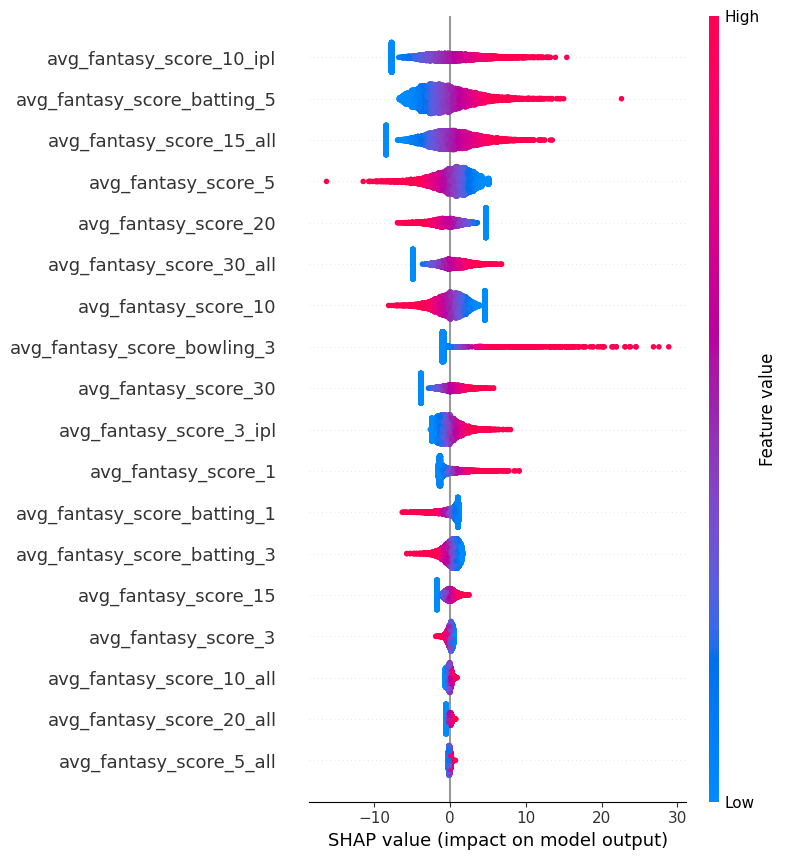

In [118]:

model = trained_models["linear_regression_model"]["model"]
#X_sample = X_train[:1000]  # Avoid full dataset if large

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)


In [119]:
import joblib

joblib.dump(model,'/Users/tamoghnakumar/Desktop/fantasy_model_docker/model_batsman.pkl')

['/Users/tamoghnakumar/Desktop/fantasy_model_docker/model_batsman.pkl']

In [120]:
# todays date

# train,test=split(df,pd.to_datetime('today').strftime('%Y-%m-%d'))
train,test=split(bowler,'2025-05-20')

In [121]:
bowler.columns

Index(['match_id', 'date', 'total_fantasy_score', 'player_id',
       'batting_points', 'bowling_points', 'avg_fantasy_score_1_all',
       'avg_fantasy_score_3_all', 'avg_fantasy_score_5_all',
       'avg_fantasy_score_10_all', 'avg_fantasy_score_15_all',
       'avg_fantasy_score_20_all', 'avg_fantasy_score_30_all',
       'avg_fantasy_score_batting_3', 'avg_fantasy_score_bowling_3',
       'avg_fantasy_score_batting_5', 'avg_fantasy_score_bowling_5',
       'avg_fantasy_score_batting_1', 'avg_fantasy_score_bowling_1',
       'avg_fantasy_score_1', 'avg_fantasy_score_3', 'avg_fantasy_score_5',
       'avg_fantasy_score_10', 'avg_fantasy_score_15', 'avg_fantasy_score_20',
       'series', 'avg_fantasy_score_30', 'venue', 'avg_fantasy_score_1_ipl',
       'avg_fantasy_score_3_ipl', 'avg_fantasy_score_5_ipl',
       'avg_fantasy_score_10_ipl', 'avg_fantasy_score_15_ipl',
       'avg_fantasy_score_20_ipl'],
      dtype='object')

In [122]:
cols=[   'avg_fantasy_score_3_all',
       'avg_fantasy_score_5_all', 'avg_fantasy_score_10_all',
       'avg_fantasy_score_15_all', 'avg_fantasy_score_20_all',
       'avg_fantasy_score_30_all', 'avg_fantasy_score_batting_3',
       'avg_fantasy_score_bowling_3', 
       'avg_fantasy_score_bowling_1', 'avg_fantasy_score_batting_5', 'avg_fantasy_score_bowling_5',
       'avg_fantasy_score_3', 'avg_fantasy_score_5', 'avg_fantasy_score_10',  'series',
       'avg_fantasy_score_30', 
       'avg_fantasy_score_3_ipl', 
       'avg_fantasy_score_10_ipl', 
       'total_fantasy_score']
X_train=train[cols]
X_test=test[cols]

In [123]:
X_test=X_test[X_test['series']=='Indian Premier League']
y_train=X_train['total_fantasy_score']
y_test=X_test['total_fantasy_score']

X_train.drop('total_fantasy_score',axis=1, inplace=True)
X_train.drop('series',axis=1, inplace=True)

X_test.drop('series',axis=1, inplace=True)
X_test.drop('total_fantasy_score',axis=1, inplace=True)

/var/folders/wc/yydrg2wj7zb6sxtvg6h8nmcw0000gn/T/ipykernel_38370/4113080693.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop('total_fantasy_score',axis=1, inplace=True)
/var/folders/wc/yydrg2wj7zb6sxtvg6h8nmcw0000gn/T/ipykernel_38370/4113080693.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop('series',axis=1, inplace=True)


In [124]:
X_train=X_train.fillna(0)
X_test=X_test.fillna(0)

In [125]:
features = X_train.columns.tolist()

with open("features_bowler.txt", "w") as f:
    for feature in features:
        f.write(f"{feature}\n")

In [126]:
#trained_models=train_stacked_model_regression(X_train, y_train)
trained_models=train_linear_regression(X_train, y_train)

Training Linear Regression model...


In [127]:
def avg_percentage_error_per_model(predictions):
    percentage_error_per_model = {
        model_name: 0 
        for model_name in predictions.columns 
        if '_predicted_score' in model_name
    }
    num_matches = predictions['match_id'].nunique()

    for match_id in predictions['match_id'].unique():
        match_data = predictions[predictions['match_id'] == match_id]

        for model_name in percentage_error_per_model:
            # True Top 11 (based on total_fantasy_score)
            match_data_sorted_model = match_data.sort_values(by='total_fantasy_score', ascending=False)
            top_11_true = match_data_sorted_model['total_fantasy_score'].iloc[:11].copy()
            if len(top_11_true) > 0:
                top_11_true.iloc[0] *= 2
            if len(top_11_true) > 1:
                top_11_true.iloc[1] *= 1.5

            # Predicted Top 11 (based on model's predicted score)
            model_sorted = match_data.sort_values(by=model_name, ascending=False)
            top_batsmen = model_sorted[model_sorted['batsman'] == 1].head(6)
            top_bowlers = model_sorted[model_sorted['batsman'] == 0].head(5)
            top_11_predicted = pd.concat([top_batsmen, top_bowlers])['total_fantasy_score'].copy()

            if len(top_11_predicted) > 0:
                top_11_predicted.iloc[0] *= 2
            if len(top_11_predicted) > 1:
                top_11_predicted.iloc[1] *= 1.5

            top_11_sum_true = top_11_true.sum()
            top_11_sum_predicted = top_11_predicted.sum()

            if top_11_sum_true != 0:
                percentage_error = abs(top_11_sum_predicted - top_11_sum_true) / top_11_sum_true * 100
            else:
                percentage_error = 0

            percentage_error_per_model[model_name] += percentage_error

    avg_percentage_error_per_model = {
        model_name: total_error / num_matches 
        for model_name, total_error in percentage_error_per_model.items()
    }

    return avg_percentage_error_per_model


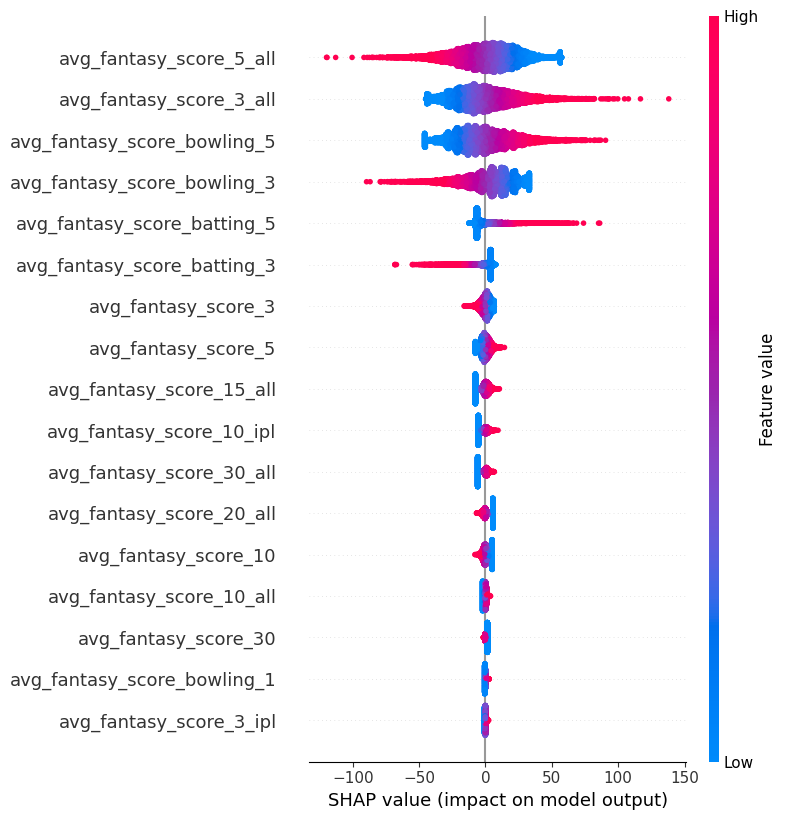

In [128]:

model = trained_models["linear_regression_model"]["model"]
#X_sample = X_train[:1000]  # Avoid full dataset if large

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)


In [129]:
import joblib

joblib.dump(model,'/Users/tamoghnakumar/Desktop/fantasy_model_docker/model_bowler.pkl')

['/Users/tamoghnakumar/Desktop/fantasy_model_docker/model_bowler.pkl']